# Chapter 3. Foundational Components of Neural Networks

In [1]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt

In [2]:
class Perceptron(nn.Module):
    """ A perceptron is one linear layer """
    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x_in):
        """ The forward pass of the perceptron

        Args:
            x_in (torch.Tensor): an input data tensor
                x_in.shape shoud be (batch, num_features)
        Returns:
            the resulting tensor. tensor.shape shoud be (batch,).
        """
        return torch.sigmoid(self.fc1(x_in)).squeeze()



## Activation Functions

### Sigmoid

As you can observe from the plot, the sigmoid function saturates (i.e., produces extreme valued outputs) very quickly and for a majority of the inputs. This can become a problem because it can lead to the gradients becoming either zero or diverging to an overflowing floating-point value. These phenomena are also known as vanishing gradient problem and exploding gradient problem, respectively. As a consequence, it is rare to see sigmoid units used in neural networks other than at the output, where the squashing property allows one to interpret outputs as probabilities.

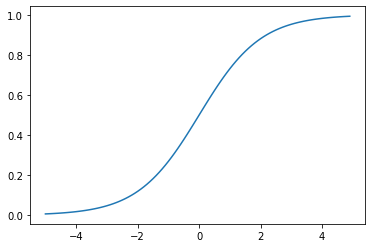

In [3]:
x = torch.arange(-5., 5., 0.1)
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

### Tanh

The tanh activation function is a cosmetically different variant of the sigmoid. This becomes clear when you write down the expression for tanh. Notice that tanh, like the sigmoid, is also a “squashing” function, except that it maps the set of real values from (–∞, +∞) to the range [-1, +1].


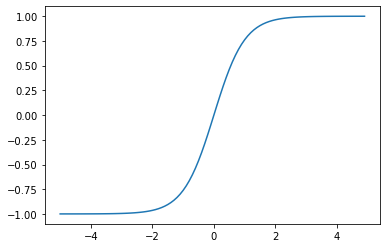

In [4]:
x = torch.arange(-5., 5., 0.1)
y = torch.tanh(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

###  ReLU

ReLU (pronounced ray-luh) stands for rectified linear unit. This is arguably the most important of the activation functions. In fact, one could venture as far as to say that many of the recent innovations in deep learning would’ve been impossible without the use of ReLU. For something so fundamental, it’s also surprisingly new as far as neural network activation functions go. And it’s surprisingly simple in form:

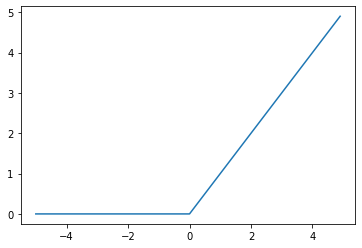

In [5]:
relu = torch.nn.ReLU()
x = torch.arange(-5., 5., 0.1)
y = relu(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

### PReLU

The clipping effect of ReLU that helps with the vanishing gradient problem can also become an issue, where over time certain outputs in the network can simply become zero and never revive again. This is called the “dying ReLU” problem. To mitigate that effect, variants such as the Leaky ReLU and Parametric ReLU (PReLU) activation functions have proposed, where the leak coefficient a is a learned parameter. Example 3-5 shows the result.

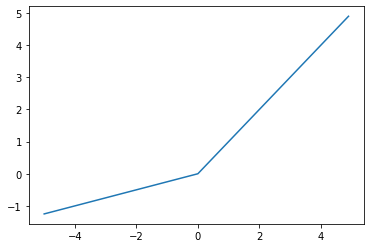

In [8]:
prelu = torch.nn.PReLU(num_parameters=1)
x = torch.arange(-5., 5., 0.1)
y = prelu(x)
plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

### Softmax

Another choice for the activation function is the softmax. Like the sigmoid function, the softmax function squashes the output of each unit to be between 0 and 1, as shown in Example 3-6. However, the softmax operation also divides each output by the sum of all the outputs, which gives us a discrete probability distribution3 over k possible classes.The probabilities in the resulting distribution all sum up to one. This is very useful for interpreting outputs for classification tasks, and so this transformation is usually paired with a probabilistic training objective, such as categorical cross entropy, which is covered in “Diving Deep into Supervised Training”.

In [9]:
softmax = nn.Softmax(dim=1)
x_input = torch.randn(1, 3)
y_output = softmax(x_input)
print(x_input)
print(y_output)
print(torch.sum(y_output, dim=1))

tensor([[0.2575, 1.1527, 1.5247]])
tensor([[0.1429, 0.3498, 0.5074]])
tensor([1.])


## Loss Functions

Recall that a loss function takes a truth (y) and a prediction (ŷ) as an input and produces a real-valued score. The higher this score, the worse the model’s prediction is. PyTorch implements more loss functions in its nn package than we can cover here, but we will review some of the most commonly used loss functions.

### Mean Squared Error (MSE) Loss

For regresssion problems for which the networks's output (y_hat) and the target (y) are continuous values, one common loss function is the mean squared error (MSE). The MSE is simplu the average of the squares of the differences between the predicted and target values. MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error) are variants that involve computing a real-valued distance between the output and the target 

In [11]:
mse_loss = nn.MSELoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.randn(3, 5)
loss = mse_loss(outputs, targets)
print(loss)

tensor(1.6569, grad_fn=<MseLossBackward>)


### Categorical Cross-Entropy Loss

The categorical cross-entropy loss is typically used in a multiclass classification setting in which the outputs are interpreted as predictions of class membership probabilities. The target (y) is a vector of n elements that represents the true multinomial distribution4 over all the classes. If only one class is correct, this vector is a one-hot vector. The network’s output (ŷ) is also a vector of n elements but represents the network’s prediction of the multinomial distribution. Categorical cross entropy will compare these two vectors (y,ŷ) to measure the loss.
Cross-entropy and the expression for it have origins in information theory, but for the purpose of this section it is helpful to consider this as a method to compute how different two distributions are. We want the probability of the correct class to be close to 1, whereas the other classes have a probability close to 0.



In [16]:
ce_loss = nn.CrossEntropyLoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.tensor([1, 0, 3], dtype=torch.int64)
loss = ce_loss(outputs, targets)
print(loss)

tensor(2.1971, grad_fn=<NllLossBackward>)


### Binary Cross-Entropy Loss

The categorical cross-entropy loss function we saw in the previous section is very useful in classification problems when we have multiple classes. Sometimes, our task involves discriminating between two classes—also known as binary classification. For such situations, it is efficient to use the binary cross-entropy (BCE) loss. We look at this loss function in action in “Example: Classifying Sentiment of Restaurant Reviews”.

In [17]:
bce_loss = nn.BCELoss()
sigmoid = nn.Sigmoid()
probabilities = sigmoid(torch.randn(4, 1, requires_grad=True))
targets = torch.tensor([1, 0, 1, 0], dtype=torch.float32).view(4, 1)
loss = bce_loss(probabilities, targets)
print(probabilities)
print(loss) 

tensor([[0.7596],
        [0.8517],
        [0.0669],
        [0.7049]], grad_fn=<SigmoidBackward>)
tensor(1.5272, grad_fn=<BinaryCrossEntropyBackward>)


## Diving Deep into Supervised Learning

Supervised learning is the problem of learning how to map observations to specified targets given labeled examples. In this section, we go into more detail. Specifically, we explicitly describe how to use model predictions and a loss function to do gradient-based optimization of a model’s parameters.

Supervised learning requires the following: a model, a loss function, training data, and an optimization algorithm. The training data for supervised learning is pairs of observations and targets; the model computes predictions from the observations, and the loss measures the error of the predictions as compared to the targets. The goal of the training is to use the gradient-based optimization algorithm to adjust the model’s parameters so that the losses are as low as possible.

In the remainder of this section, we discuss a classic toy problem: classifying two-dimensional points into one of two classes. Intuitively, this means learning a single line, called a *decision boundary or hyperplane*, to discriminate the points of one class from the other. We step through and describe the data construction, choosing the model, selecting a loss function, setting up the optimization algorithm, and, finally, running it all together.

### Constructing Toy data
